In [ ]:
import pandas as pd
from pathlib import Path
from mlsynth import FDID

In [ ]:
def run_fdid_batch(directory: Path = Path.cwd()) -> dict:
    """
    Loads all CSVs from a directory, filters and reformats the data,
    then runs FDID on each 'ntl*' outcome variable in each file.

    Returns:
        dict: A dictionary of FDID model results keyed by filename and outcome name.
    """

    def load_and_filter_csvs(directory: Path) -> list[tuple[str, pd.DataFrame]]:
        def parse_quarter_date(qstr):
            year, quarter = qstr.split("_Q")
            month = (int(quarter) - 1) * 3 + 1
            return pd.to_datetime(f"{year}-{month:02d}-01")

        processed = []
        for file in directory.glob("*.csv"):
            df = pd.read_csv(file)

            if "date" not in df.columns:
                continue

            df["date"] = df["date"].apply(parse_quarter_date)

            keep_cols = ["date"] + \
                        [col for col in df.columns if col.startswith("ntl")] + \
                        [col for col in ["treated", "fullname"] if col in df.columns]

            processed.append((file.stem, df[keep_cols]))

        return processed

    # Load and prepare data
    named_dfs = load_and_filter_csvs(directory)

    # Run FDID models
    results = {}

    for filename, df in named_dfs:
        outcome_cols = [col for col in df.columns if col.startswith("ntl")]

        for outcome_col in outcome_cols:
            config = {
                "df": df,
                "outcome": outcome_col,
                "treat": "treated",
                "unitid": "fullname",
                "time": "date",
                "display_graphs": False,
                "save": False,
                "counterfactual_color": ["red", "blue"],
            }

            key = f"{filename}_{outcome_col}"
            results[key] = FDID(config).fit()

    return results

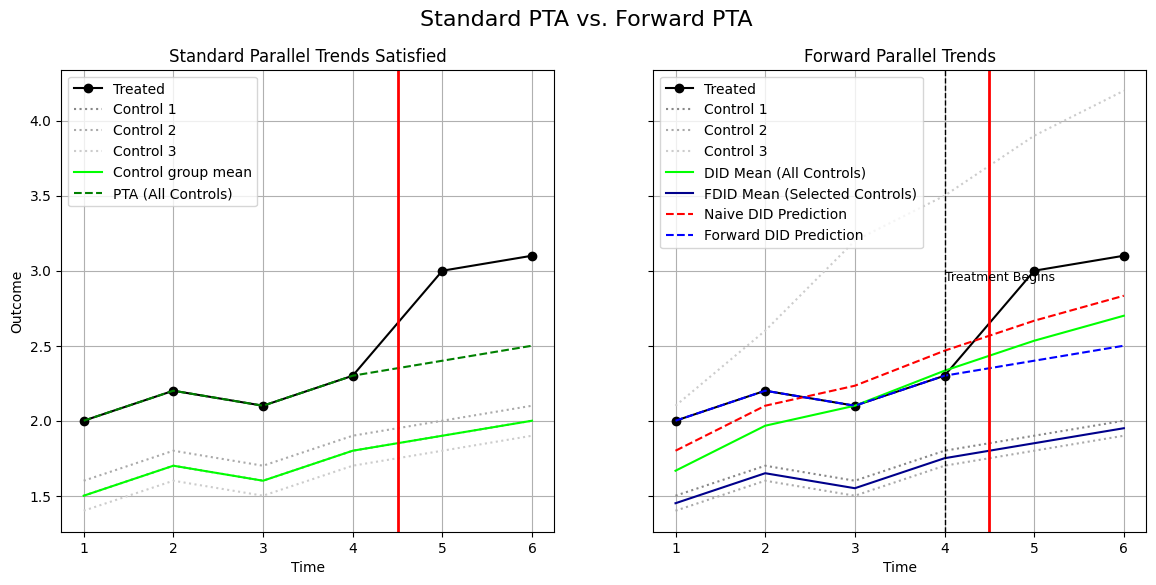

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def pta_plot():
    T1 = 4
    time = np.arange(1, 7)

    treated = np.array([2.0, 2.2, 2.1, 2.3, 3.0, 3.1])

    # Standard PTA case (all donors aligned)
    control_std1 = np.array([1.5, 1.7, 1.6, 1.8, 1.9, 2.0])
    control_std2 = np.array([1.6, 1.8, 1.7, 1.9, 2.0, 2.1])
    control_std3 = np.array([1.4, 1.6, 1.5, 1.7, 1.8, 1.9])
    avg_std_all = (control_std1 + control_std2 + control_std3) / 3
    diff_std_all = np.mean(treated[:T1] - avg_std_all[:T1])
    pta_std = avg_std_all + diff_std_all

    # Forward selection case (1 bad control)
    control1 = control_std1
    control2 = control_std3
    control3 = np.array([2.1, 2.6, 3.2, 3.5, 3.9, 4.2])
    avg_forward_all = (control1 + control2 + control3) / 3
    avg_forward_sel = (control1 + control2) / 2
    diff_all_fwd = np.mean(treated[:T1] - avg_forward_all[:T1])
    diff_sel_fwd = np.mean(treated[:T1] - avg_forward_sel[:T1])
    pta_fwd_all = avg_forward_all + diff_all_fwd
    pta_fwd_sel = avg_forward_sel + diff_sel_fwd

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Define unique gray shades for controls
    gray1 = '#888888'
    gray2 = '#aaaaaa'
    gray3 = '#cccccc'

    # Plot 1: Standard PTA
    axes[0].plot(time, treated, label='Treated', color='black', marker='o')
    axes[0].plot(time, control_std1, ':', color=gray1, label='Control 1')
    axes[0].plot(time, control_std2, ':', color=gray2, label='Control 2')
    axes[0].plot(time, control_std3, ':', color=gray3, label='Control 3')
    axes[0].plot(time, avg_std_all, '-', color='lime', label='Control group mean')
    axes[0].plot(time, pta_std, '--', color='green', label='PTA (All Controls)')
    axes[0].axvline(x=T1 + 0.5, color='red', linestyle='-', linewidth=2)
    axes[0].set_title('Standard Parallel Trends Satisfied')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Forward PTA
    axes[1].plot(time, treated, label='Treated', color='black', marker='o')
    axes[1].plot(time, control1, ':', color=gray1, label='Control 1')
    axes[1].plot(time, control2, ':', color=gray2, label='Control 2')
    axes[1].plot(time, control3, ':', color=gray3, label='Control 3')
    axes[1].plot(time, avg_forward_all, '-', color='lime', label='DID Mean (All Controls)')
    axes[1].plot(time, avg_forward_sel, '-', color='darkblue', label='FDID Mean (Selected Controls)')
    axes[1].plot(time, pta_fwd_all, '--', color='red', label='Naive DID Prediction')
    axes[1].plot(time, pta_fwd_sel, '--', color='blue', label='Forward DID Prediction')
    axes[1].axvline(x=T1, color='black', linestyle='--', linewidth=1)
    axes[1].axvline(x=T1 + 0.5, color='red', linestyle='-', linewidth=2)  # Additional reference line
    axes[1].set_title('Forward Parallel Trends')
    axes[1].set_xlabel('Time')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle('Standard PTA vs. Forward PTA', fontsize=16)
    plt.show()


pta_plot()



results = run_fdid_batch(Path.cwd())

In [ ]:
def dump_results_to_text(results: dict, output_file: str = "fdid_did_outputs.txt") -> None:
    """
    Dump FDID and DID result summaries from a results dictionary to a text file.

    Parameters:
        results (dict): The dictionary of fitted FDID models.
        output_file (str): The name of the output text file.
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for key, models in results.items():
            f.write(f"\n===== Results for {key} =====\n")

            # FDID
            f.write("\n--- FDID ---\n")
            fdid_model = models[0]
            for section in ["Effects", "Fit", "Inference", "Weights"]:
                if section in fdid_model.raw_results:
                    f.write(f"\n[{section}]\n")
                    f.write(f"{fdid_model.raw_results[section]}\n")

            # DID
            f.write("\n--- DID ---\n")
            did_model = models[1]
            for section in ["Effects", "Fit", "Inference"]:  # no Weights
                if section in did_model.raw_results:
                    f.write(f"\n[{section}]\n")
                    f.write(f"{did_model.raw_results[section]}\n")

            f.write("\n" + "="*50 + "\n")

In [ ]:
dump_results_to_text(results, "fdid_summary_output.txt")